<a href="https://colab.research.google.com/github/RoadoneP/Machine_learning/blob/main/Waste_classification/waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [2]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

In [4]:
! kaggle datasets download -d techsash/waste-classification-data

100% 427M/427M [00:02<00:00, 240MB/s]
100% 427M/427M [00:02<00:00, 157MB/s]


In [ ]:
!unzip waste-classification-data.zip

# 라이브러리

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, Dropout, Input
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.engine.topology import Layer
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#데이터 불러오기 및 처리

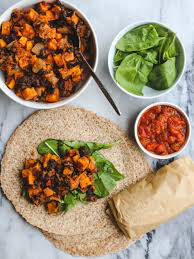

In [9]:
Image.open('/content/dataset/DATASET/TEST/O/O_13191.jpg')

In [11]:
train_dir = '/content/dataset/DATASET/TRAIN'
test_dir = '/content/dataset/DATASET/TEST'

def load_dataset(path):
  data = load_files(path) # 경로에서 파일 탐색
  files = np.array(data['filenames']) #파일 가져오기
  targets = np.array(data['target'])

  target_labels = np.array(data['target_names'])

  return files,targets,target_labels

x_train, y_train, target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
print(target_labels)
print(np.unique(y_train))
print('Training set size : ', x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

['O' 'R']
[0 1]
Training set size :  22564
Testing set size :  2513


In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.2, random_state = 1)

In [13]:
print("x_train shape: ",x_train.shape[0])
print("y_train shape: ",y_train.shape[0])
print("x_val shape: ",x_val.shape[0])
print("y_val shape: ",y_val.shape[0])
print("x_test shape: ",x_test.shape[0])
print("y_test shape: ",y_test.shape[0])

x_train shape:  18051
y_train shape:  18051
x_val shape:  4513
y_val shape:  4513
x_test shape:  2513
y_test shape:  2513


# jpg to numpy array

(64, 64, 3)


Text(0.5, 0, '1')

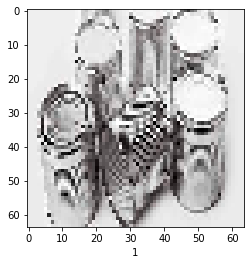

In [14]:
img = cv2.imread(x_train[0], cv2.IMREAD_COLOR)
res = cv2.resize(img,dsize=(64, 64), interpolation = cv2.INTER_CUBIC)
print(res.shape)
plt.imshow(res)
plt.xlabel(y_train[0])

In [15]:
def convert_image_to_array(files):
  width, height, channels = 64, 64, 3
  images_as_array = np.empty((files.shape[0],width, height, channels), dtype = np.uint8)
  for idx, file in enumerate(files):
    img = cv2.imread(file)
    #이미지의 크기가 다르므로 모든 이미지의 크기를 동일한 이미지 배열 모양으로 조정
    res = cv2.resize(img, dsize = (width,height), interpolation = cv2.INTER_CUBIC)
    images_as_array[idx] = res
  return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_val = np.array(convert_image_to_array(x_val))
print('Validation set shape : ',x_val.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Training set shape :  (18051, 64, 64, 3)
Validation set shape :  (4513, 64, 64, 3)
Test set shape :  (2513, 64, 64, 3)


In [16]:
x_train = x_train.astype('float32')/255
x_val = x_val.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
y_val = y_val.reshape(y_val.shape[0],1)

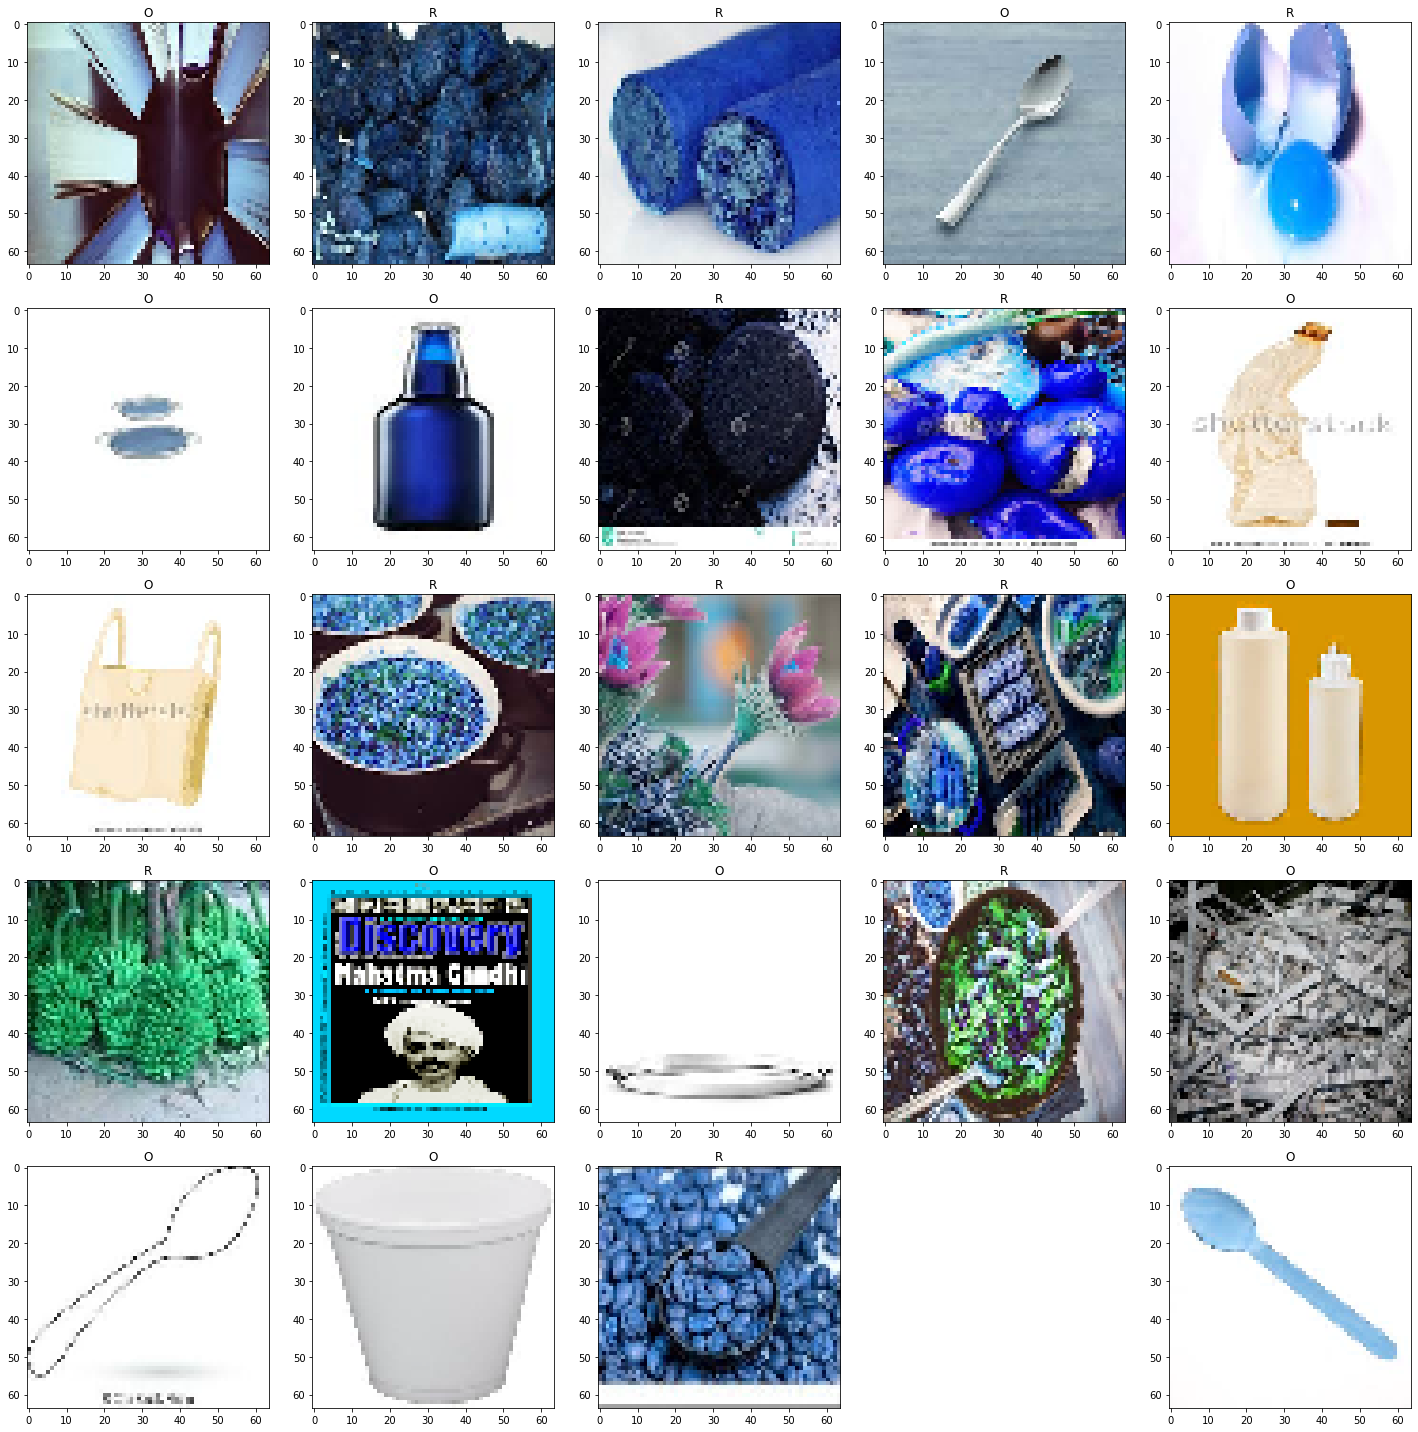

In [17]:
plt.figure(figsize=(20,20))
classes = ['R','O']
for i in range(1,26):
  index = np.random.randint(x_train.shape[0])
  plt.subplot(5, 5, i)
  plt.imshow(np.squeeze(x_train[index]), cmap='cool')
  plt.title(classes[int(y_train[index])])
  plt.tight_layout()
plt.show()

#Image augment

In [18]:
datagen = ImageDataGenerator(
    featurewise_center=False, #데이터 세트에 대해 입력 평균을 0으로 설정
    samplewise_center=False, #각 샘플 평균을 0으로 설정
    featurewise_std_normalization=False, # 데이터 세트의 표준으로 입력을 나눕니다.
    samplewise_std_normalization=False,  # 각 입력을 표준으로 나눕니다.
    zca_whitening=False,
    rotation_range = 0, #이미지 무작위 회전
    zoom_range = 0.1, #이미지 무작위 줌
    width_shift_range=0.2, #이미지 가로 이동
    height_shift_range=0.2, #이미지 세로 이동
    horizontal_flip=True, #이미지 뒤집기
    vertical_flip=False  #이미지 뒤집기
)
datagen.fit(x_train)

#model

In [33]:
def build_model():
  model = Sequential()

  input = Input(shape=(64,64,3))
  output = Conv2D(32,kernel_size=(3, 3),kernel_initializer='he_normal', activation='relu')(input)
  output = Conv2D(32, kernel_size=(3, 3),activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPooling2D(pool_size=(2, 2))(output)
  output = Dropout(0.2)(output)

  output = Conv2D(64, kernel_size=(3, 3),activation='relu')(output)
  output = Conv2D(64, kernel_size=(3, 3),activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPooling2D(pool_size=(2, 2))(output)
  output = Dropout(0.2)(output)

  output = Conv2D(128, kernel_size=(3, 3),activation='relu')(output)
  output = Conv2D(128, kernel_size=(3, 3),activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPooling2D(pool_size=(2, 2))(output)
  output = Dropout(0.3)(output)

  #output = Conv2D(256, kernel_size=(3, 3),activation='relu')(output)
  #output = Conv2D(256, kernel_size=(3, 3),activation='relu')(output)
  #output = BatchNormalization()(output)
  #output = MaxPooling2D(pool_size=(2, 2))(output)
  #output = Dropout(0.3)(output)

  output = Flatten()(output)
  #output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)
  output = Dropout(0.3)(output)
  output = Dense(1, activation='sigmoid')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

model = build_model()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 64)        1849

Epoch 훈련 반복 중에 가장 낮은 손실이 달성되면 모델을 저장.

In [34]:
checkpoint = ModelCheckpoint(filepath='cnn.hdf5', verbose= 1 , save_best_only= True)

또한 Epoch 훈련 반복으로 손실이 감소하지 않는 경우 모델 훈련을 중지

In [38]:
earlystop = EarlyStopping(monitor='val_loss', min_delta= 0 , patience= 10, verbose= 1, restore_best_weights= True)

개선이 보이지 않으면 학습률을 줄인다.

In [39]:
ReduceLR = ReduceLROnPlateau(patience=3, verbose=1)

In [40]:
callbacks = [earlystop, checkpoint, ReduceLR]

In [41]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size= 32), epochs = 80, verbose=1,callbacks = callbacks,validation_data=(x_val,y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
565/565 [==============================] - 23s 40ms/step - loss: 0.5591 - acc: 0.7550 - val_loss: 0.4311 - val_acc: 0.7908

Epoch 00001: val_loss improved from inf to 0.43108, saving model to cnn.hdf5
Epoch 2/80
565/565 [==============================] - 22s 39ms/step - loss: 0.4269 - acc: 0.8156 - val_loss: 0.4348 - val_acc: 0.8154

Epoch 00002: val_loss did not improve from 0.43108
Epoch 3/80
565/565 [==============================] - 22s 39ms/step - loss: 0.4074 - acc: 0.8297 - val_loss: 0.3847 - val_acc: 0.8495

Epoch 00003: val_loss improved from 0.43108 to 0.38473, saving model to cnn.hdf5
Epoch 4/80
565/565 [==============================] - 22s 39ms/step - loss: 0.3824 - acc: 0.8431 - val_loss: 0.3609 - val_acc: 0.8453

Epoch 00004: val_loss improved from 0.38473 to 0.36094, saving model to cnn.hdf5
Epoch 5/80
565/565 [==============================] - 22s 39ms/step - loss: 0.3585 - acc: 0.8580 - val_loss: 0.3223 - val_acc: 0.8690

Epoch 00005: val_loss improved from

In [42]:
import pickle

pickle_out = open("Trained_cnn_history.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [43]:
pickle_in = open("Trained_cnn_history.pickle","rb")
saved_history = pickle.load(pickle_in)
print(saved_history)

{'loss': [0.4950203001499176, 0.4205247163772583, 0.39905834197998047, 0.38055819272994995, 0.3610316514968872, 0.35695159435272217, 0.34962084889411926, 0.3402461111545563, 0.3350176215171814, 0.3220290541648865, 0.31636279821395874, 0.290639191865921, 0.28240489959716797, 0.27555739879608154, 0.27366551756858826, 0.2722761332988739, 0.27236881852149963, 0.2658533751964569, 0.263936311006546, 0.2548310458660126, 0.26224467158317566, 0.26002800464630127, 0.2663112282752991, 0.2586060166358948, 0.25938981771469116, 0.26230886578559875, 0.2623348832130432, 0.26037102937698364, 0.2608894109725952, 0.26229310035705566, 0.26237842440605164, 0.25849759578704834, 0.26080766320228577, 0.261079341173172, 0.2589053213596344], 'acc': [0.7825050950050354, 0.8183479905128479, 0.8336934447288513, 0.844883918762207, 0.8559082746505737, 0.8543016910552979, 0.8595091700553894, 0.8626669049263, 0.8657692074775696, 0.873691201210022, 0.8764611482620239, 0.8859342932701111, 0.8915849328041077, 0.893579304

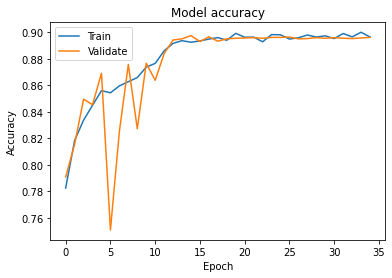

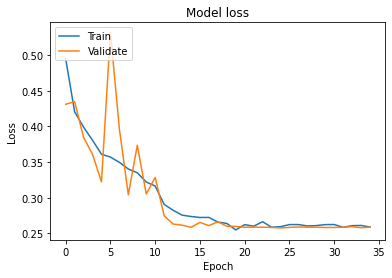

In [44]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [45]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss :',score[0])
print('Test Accuracy :',score[1])

Test Loss : 0.24377194046974182
Test Accuracy : 0.9188221096992493
